# ICAL pipeline processing using Dask workflows.

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame

from wrappers.serial.calibration.calibration import solve_gaintable
from wrappers.serial.calibration.calibration_control import create_calibration_controls
from wrappers.serial.image.operations import show_image, export_image_to_fits, qa_image
from wrappers.serial.simulation.testing_support import create_low_test_skymodel_from_gleam
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field, \
    predict_skycomponent_visibility
from wrappers.arlexecute.image.gather_scatter import image_gather_channels
from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility, \
    convert_visibility_to_blockvisibility

from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow, \
    weight_list_arlexecute_workflow, \
    taper_list_arlexecute_workflow, remove_sumwt

from workflows.arlexecute.simulation.simulation_arlexecute import simulate_list_arlexecute_workflow, \
    corrupt_list_arlexecute_workflow
from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import predict_skymodel_list_arlexecute_workflow

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

### We will use dask to distribute processing

In [3]:
client = get_dask_Client(memory_limit=4 * 1024 * 1024 * 1024, n_workers=7, threads_per_worker=1)
arlexecute.set_client(client)

Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:8787


### All Dask workers log to a common file

In [4]:
import logging

def init_logging():
    log = logging.getLogger()
    logging.basicConfig(filename='%s/arl_demo.log' % results_dir,
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.INFO)
log = logging.getLogger()
logging.info("Starting ARL ICAL demo")
arlexecute.run(init_logging)

{'tcp://127.0.0.1:60643': None,
 'tcp://127.0.0.1:60644': None,
 'tcp://127.0.0.1:60647': None,
 'tcp://127.0.0.1:60648': None,
 'tcp://127.0.0.1:60651': None,
 'tcp://127.0.0.1:60653': None,
 'tcp://127.0.0.1:60657': None}

### We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All other parameters are determined from this number.

In [5]:
nfreqwin=7
ntimes=5
rmax=600.0
frequency=numpy.linspace(0.9e8,1.1e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/4.0, numpy.pi/4.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

blockvis_list=simulate_list_arlexecute_workflow('LOWBD2',
                                                frequency=frequency, 
                                                channel_bandwidth=channel_bandwidth,
                                                times=times,
                                                phasecentre=phasecentre, 
                                                order='frequency', format='blockvis',
                                                rmax=rmax)
blockvis_list = arlexecute.compute(blockvis_list, sync=True)
print('%d rows in block vis_list' % len(blockvis_list))

arlexecute.compute: Execution using Dask took 2.417 seconds
7 rows in block vis_list


Create row oriented visibility

In [6]:
future_blockvis_list = arlexecute.scatter(blockvis_list)
vis_list = [arlexecute.execute(convert_blockvisibility_to_visibility)(bv) 
            for bv in future_blockvis_list]
vis_list = arlexecute.compute(vis_list, sync=True)
print('%d rows in vis_list' % len(vis_list))

arlexecute.compute: Execution using Dask took 3.417 seconds
7 rows in vis_list


In [7]:
import pprint
pp = pprint.PrettyPrinter()

advice=advise_wide_field(vis_list[-1], guard_band_image=6.0, delA=0.1, 
                         oversampling_synthesised_beam=4)
pp.pprint(advice)
context='wstack'
vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']
use_serial_imaging=False

{'cellsize': 0.0006451011381954267,
 'delA': 0.1,
 'diameter': 35.0,
 'facet_fov': 0.46720902545454546,
 'facets': 1,
 'freq_sampling_image': 58921.43149486531,
 'freq_sampling_primary_beam': 2121171.5338151515,
 'guard_band_image': 6.0,
 'image_fov': 0.46720902545454546,
 'max_wavelength': 2.725385981818182,
 'maximum_baseline': 387.53613224019006,
 'min_wavelength': 2.725385981818182,
 'npixels': 724,
 'npixels2': 1024,
 'npixels23': 768,
 'nwpixels': 112,
 'oversampling_synthesised_beam': 4,
 'primary_beam_fov': 0.07786817090909091,
 'synthesized_beam': 0.002580404552781707,
 'time_sampling_image': 46.28010619233058,
 'time_sampling_primary_beam': 1666.0838229239007,
 'vis': <data_models.memory_data_models.Visibility object at 0x11e63bf60>,
 'vis_slices': 33,
 'w_sampling_facet': 0.6521427605525,
 'w_sampling_image': 0.6521427605525,
 'w_sampling_primary_beam': 23.477139379889998,
 'wprojection_planes': 33,
 'wstep': 23.477139379889998}


### Now make and compute a graph to fill a skymodel drawn from GLEAM. Specify a quadratic so that we can fit it. 

In [8]:
gleam_skymodel = [arlexecute.execute(create_low_test_skymodel_from_gleam)
                     (npixel=npixel, cellsize=cellsize, frequency=[frequency[f]],
                      phasecentre=phasecentre,
                      polarisation_frame=PolarisationFrame("stokesI"),
                      flux_limit=0.3,
                      flux_threshold=1.0,
                      flux_max=5.0,
                      kind='quadratic') for f, freq in enumerate(frequency)]
gleam_skymodel = arlexecute.compute(gleam_skymodel, sync=True)


arlexecute.compute: Execution using Dask took 23.606 seconds


### Now predict the visibility from this model

In [9]:
future_gleam_skymodel = arlexecute.scatter(gleam_skymodel)
future_vis_list = arlexecute.scatter(vis_list)
gleam_skymodel = arlexecute.scatter(gleam_skymodel)
predicted_vislist = predict_skymodel_list_arlexecute_workflow(future_vis_list, 
                                                              future_gleam_skymodel, 
                                                              context=context, 
                                                              vis_slices=vis_slices,
                                                              facets=1,
                                                              use_serial_predict=use_serial_imaging)
predicted_vislist = arlexecute.compute(predicted_vislist, sync=True)

arlexecute.compute: Execution using Dask took 54.130 seconds


### Get the LSM. This is currently blank.

In [10]:
model_list = [arlexecute.execute(create_image_from_visibility)
              (vis_list[f],
               npixel=1200,
               frequency=[frequency[f]],
               channel_bandwidth=[channel_bandwidth[f]],
               cellsize=cellsize, phasecentre=phasecentre,
               polarisation_frame=PolarisationFrame("stokesI"))
               for f, freq in enumerate(frequency)]
model_list = arlexecute.compute(model_list, sync=True)

arlexecute.compute: Execution using Dask took 1.556 seconds


### Weight the data

In [11]:
future_model_list = arlexecute.scatter(model_list)
future_predicted_vislist = arlexecute.scatter(predicted_vislist)
predicted_vislist = weight_list_arlexecute_workflow(future_predicted_vislist, 
                                                    future_model_list)
predicted_vislist = taper_list_arlexecute_workflow(predicted_vislist, 0.003)
predicted_vislist = arlexecute.compute(predicted_vislist, sync=True)

arlexecute.compute: Execution using Dask took 6.385 seconds


### Add phase errors

In [12]:
future_predicted_vislist = arlexecute.scatter(predicted_vislist)
predicted_blockvislist = [arlexecute.execute(convert_visibility_to_blockvisibility, nout=1)(v) 
                      for v in future_predicted_vislist]
predicted_blockvislist = arlexecute.compute(predicted_blockvislist, sync=True)
future_predicted_blockvislist = arlexecute.scatter(predicted_blockvislist)
corrupted_blockvislist = corrupt_list_arlexecute_workflow(future_predicted_blockvislist, 
                                                          phase_error=1.0, seed=180555)
corrupted_blockvislist = arlexecute.compute(corrupted_blockvislist, sync=True)
future_corrupted_blockvislist = arlexecute.scatter(corrupted_blockvislist)
corrupted_vislist = [arlexecute.execute(convert_blockvisibility_to_visibility, nout=1)(v) 
                      for v in future_corrupted_blockvislist]
corrupted_vislist = arlexecute.compute(corrupted_vislist, sync=True)

arlexecute.compute: Execution using Dask took 2.646 seconds
arlexecute.compute: Execution using Dask took 2.666 seconds
arlexecute.compute: Execution using Dask took 3.107 seconds


### Create and execute graph to make the dirty image

arlexecute.compute: Execution using Dask took 0.001 seconds
arlexecute.compute: Execution using Dask took 46.644 seconds
Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 1200, 1200)'
		max: '1.0891313463783305'
		min: '-0.10039169796379845'
		rms: '0.021579175438200645'
		sum: '38.19328270358035'
		medianabs: '0.012363292137509465'
		median: '-0.0006181632448367476'



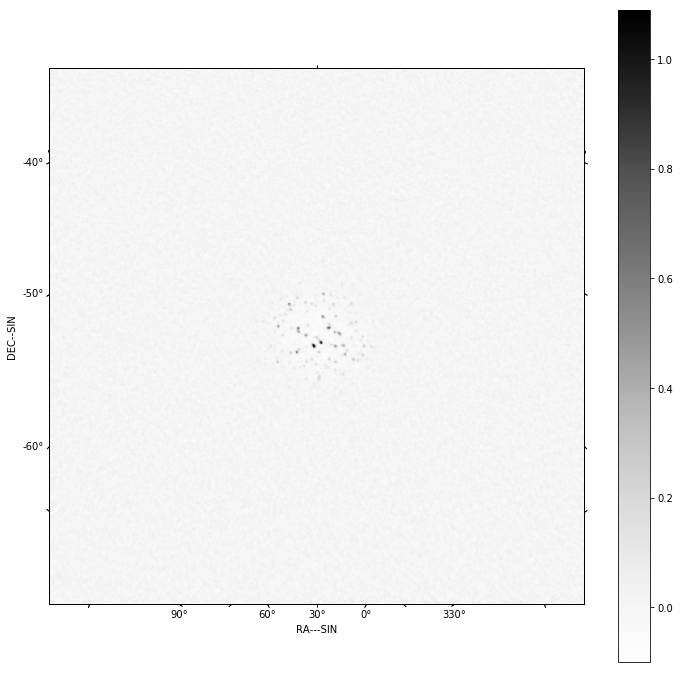

In [13]:
future_corrupted_vislist = arlexecute.compute(corrupted_vislist)
dirty_list = invert_list_arlexecute_workflow(future_corrupted_vislist, 
                                             future_model_list,
                                             context=context,
                                             vis_slices=vis_slices, dopsf=False,
                                             use_serial_invert=use_serial_imaging)

dirty_list = arlexecute.compute(dirty_list, sync=True)
dirty = dirty_list[0][0]
show_image(dirty, cm='Greys')
print(qa_image(dirty))
plt.show()
export_image_to_fits(dirty, '%s/arl_demo_ical_%s_dirty.fits' 
                     %(results_dir, context))



### ICAL with:
- timeslicing
- msmfs distributed clean (8 by 8 subimages overlapped by 16 pixels)
- selfcal for T only, across entire bands
 
First make the graph

In [14]:
controls = create_calibration_controls()
controls['T']['first_selfcal'] = 1
controls['T']['timescale'] = 'auto'

future_model_list = arlexecute.scatter(model_list)
future_corrupted_vislist = arlexecute.scatter(corrupted_vislist)

ical_list = ical_list_arlexecute_workflow(future_corrupted_vislist, 
                                          model_imagelist=future_model_list,  
                                          context=context, 
                                          vis_slices=vis_slices,
                                          scales=[0, 3, 10], 
                                          algorithm='mmclean', 
                                          nmoment=2, niter=250, 
                                          fractional_threshold=0.1,
                                          threshold=0.001, nmajor=10, 
                                          gain=0.75,
                                          psf_support=64,
                                          deconvolve_facets=8,
                                          deconvolve_overlap=32,
                                          deconvolve_taper='tukey',
                                          timeslice='auto',
                                          global_solution=True, 
                                          do_selfcal=True,
                                          calibration_context = 'T', 
                                          controls=controls,
                                          tol=1e-6,
                                          use_serial_invert=use_serial_imaging,
                                          use_serial_predict=use_serial_imaging)

### Now run the graph

arlexecute.compute: Execution using Dask took 1479.789 seconds
Quality assessment:
	Origin: qa_image
	Context: Restored clean image
	Data:
		shape: '(1, 1, 1200, 1200)'
		max: '4.362555204739324'
		min: '-0.012915265518915493'
		rms: '0.031561439401205475'
		sum: '3008.8015808563823'
		medianabs: '0.0012565412856773348'
		median: '0.00011373112248766422'



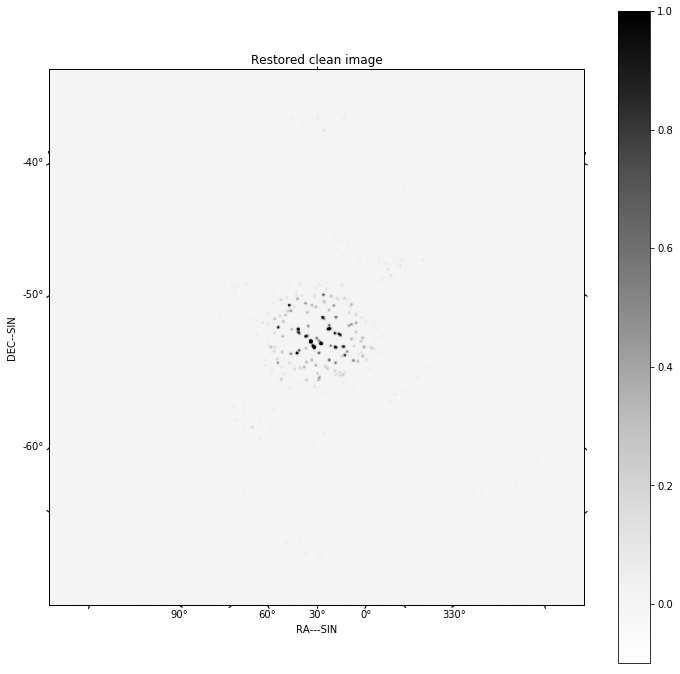

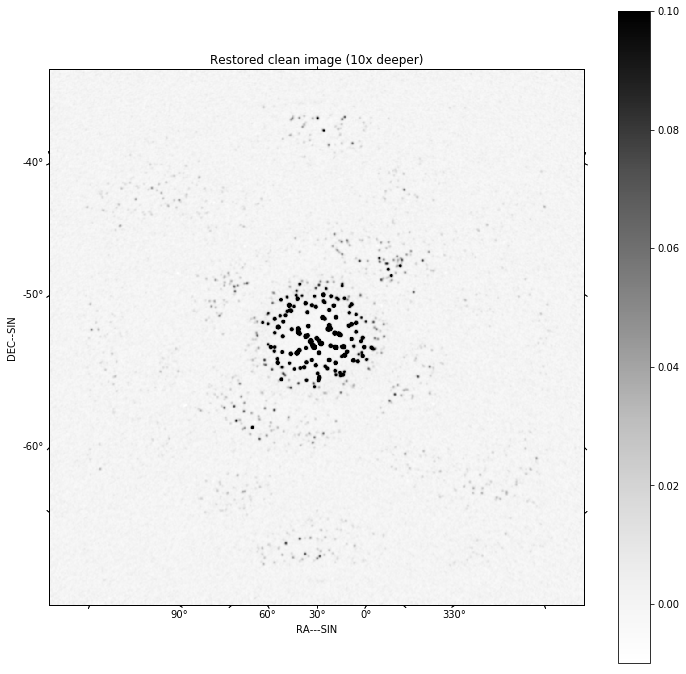

Quality assessment:
	Origin: qa_image
	Context: Residual clean image
	Data:
		shape: '(1, 1, 1200, 1200)'
		max: '0.6339894963511751'
		min: '-0.06267337691182405'
		rms: '0.0031452984945546042'
		sum: '-0.8875684732652657'
		medianabs: '0.0012217365721657342'
		median: '-8.507463545272839e-05'



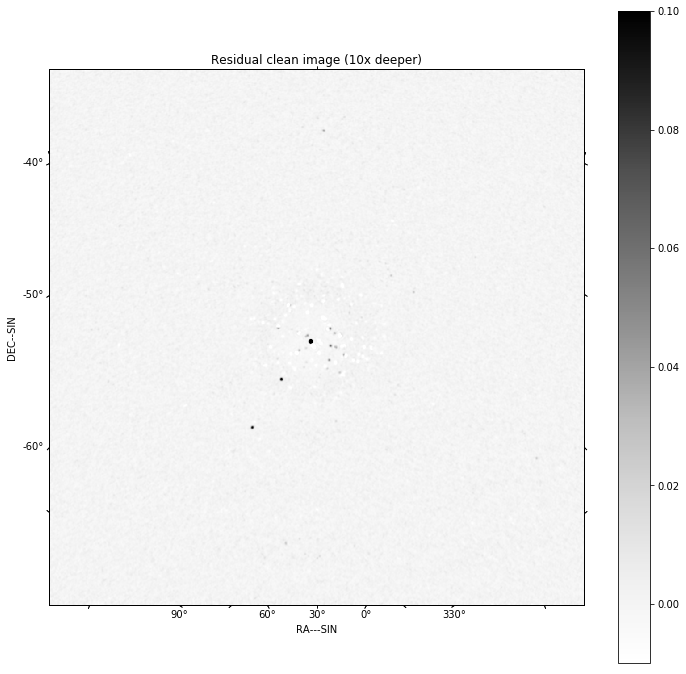

In [15]:
log.info('About to run ical')
result=arlexecute.compute(ical_list, sync=True)
centre=nfreqwin//2
residual = result[1][centre]
restored = result[2][centre]

f=show_image(restored, title='Restored clean image', cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(restored, context='Restored clean image'))
plt.show()

f=show_image(restored, title='Restored clean image (10x deeper)', cm='Greys', vmax=0.1, vmin=-0.01)
plt.show()
restored_cube = image_gather_channels(result[2])
export_image_to_fits(restored_cube, '%s/arl_demo_ical_%s_restored.fits' 
                     %(results_dir, context))

f=show_image(residual[0], title='Residual clean image (10x deeper)', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(residual[0], context='Residual clean image'))
plt.show()
export_image_to_fits(residual[0], '%s/arl_demo_ical_%s_residual.fits' 
                     %(results_dir, context))